In [1]:
from IPython.display import HTML
HTML(open('../style.css', 'r').read())

# A Simple Parser for Term Rewriting

This file implements a parser for terms and equations.  It uses the parser generator `Ply`.  To install [Ply](https://www.dabeaz.com/ply/ply.html), change the cell below into a code cell and execute it.  If the package `ply` is already installed, this command will only produce a message that the package is already installed.

In [2]:
!conda install -y -c anaconda ply

/Users/stroetmann/opt/anaconda3/lib/python3.12/site-packages/conda/base/context.py:201: FutureWarning: Adding 'defaults' to channel list implicitly is deprecated and will be removed in 25.3. 

To remove this warning, please choose a default channel explicitly with conda's regular configuration system, e.g. by adding 'defaults' to the list of channels:

  conda config --add channels defaults

For more information see https://docs.conda.io/projects/conda/en/stable/user-guide/configuration/use-condarc.html

  deprecated.topic(
doneieving notices: - 
Channels:
 - anaconda
 - defaults
Platform: osx-arm64
doneecting package metadata (repodata.json): - 
doneing environment: / 


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.1.1

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/stroetmann/opt/anaconda3/envs/ai

  added / updated specs:
    - ply


The follow

## Specification of the Scanner

The scanner that is implemented below recognizes *numbers*, *variable names*, *function symbols*, and various *operator symbols*.  Variable names have to start with a lower case letter, while function names start with an uppercase letter.

In [3]:
import ply.lex as lex

In [4]:
tokens = [ 'NUMBER', 'VAR', 'FCT', 'BACKSLASH' ]

The token `Number` specifies a *natural number*.  Syntactically, numbers are treated a *function symbols*.

In [5]:
def t_NUMBER(t):
    r'0|[1-9][0-9]*'
    return t

Variables start with a letter, followed by letters, digits, and underscores. They must be followed by a character that is not an opening parenthesis `(`.  The operator `(?=` is the *lookahead* operator.

In [6]:
def t_VAR(t):
    r'[a-zA-Z][a-zA-Z0-9_]*(?=[^(a-zA-Z0-9_])'
    return t

Function names start with a letter, followed by letters, digits, and underscores. 
They have to be followed by an opening parenthesis `(`.

In [7]:
def t_FCT(t):
    r'[a-zA-Z][a-zA-Z0-9_]*(?=[(])'
    return t

In [8]:
def t_BACKSLASH(t):
    r'\\'
    return t

Single line comments are supported and work as in `C`.

In [9]:
def t_COMMENT(t):
    r'//[^\n]*'
    t.lexer.lineno += t.value.count('\n')
    pass

The arithmetic operators and a few other symbols are supported.

In [10]:
literals = ['+', '-', '*', '/', '%', '^', '(', ')', ';', '=', ',']

White space, i.e. *space characters*, *tabulators*, and *carriage returns* are ignored. 

In [11]:
t_ignore  = ' \t\r'

Syntactically, newline characters are ignored. However, we still need to keep track of them in order to know which line we are in.  This information is needed later for error messages.

In [12]:
def t_newline(t):
    r'\n'
    t.lexer.lineno += 1
    return

Given a `token`, the function `find_colum` returns the column where `token` starts.
This is possible, because `token.lexer.lexdata` stores the string that is given to the scanner and `token.lexpos` is the number of characters that precede `token`.

In [13]:
def find_column(token):
    data       = token.lexer.lexdata
    line_start = data.rfind('\n', 0, token.lexpos) + 1
    return (token.lexpos - line_start) + 1

The function `t_error` is called for any token `t` that can not be scanned by the lexer.  In this case, `t.value[0]` is the first character that can not be recognized by the scanner.

In [14]:
def t_error(t):
    column = find_column(t)
    print(f"Illegal character '{t.value[0]}' in line {t.lineno}, column {column}.")
    t.lexer.skip(1)

The next assignment is necessary to make the lexer think that the code given above is part of some file.

In [15]:
__file__ = 'main'

In [16]:
lexer = lex.lex()

In [17]:
def test_scanner(file_name):
    with open(file_name, 'r') as handle:
        program = handle.read() 
    print(program)
    lexer.input(program)
    lexer.lineno = 1
    return [t for t in lexer]

In [18]:
for t in test_scanner('Examples/quasigroups.eqn'):
    print(t)

x * (x \ y) = y;
(x / y) * y = x;
x \ (x * y) = y;
(x * y) / y = x;
LexToken(VAR,'x',1,0)
LexToken(*,'*',1,2)
LexToken((,'(',1,4)
LexToken(VAR,'x',1,5)
LexToken(BACKSLASH,'\\',1,7)
LexToken(VAR,'y',1,9)
LexToken(),')',1,10)
LexToken(=,'=',1,12)
LexToken(VAR,'y',1,14)
LexToken(;,';',1,15)
LexToken((,'(',2,17)
LexToken(VAR,'x',2,18)
LexToken(/,'/',2,20)
LexToken(VAR,'y',2,22)
LexToken(),')',2,23)
LexToken(*,'*',2,25)
LexToken(VAR,'y',2,27)
LexToken(=,'=',2,29)
LexToken(VAR,'x',2,31)
LexToken(;,';',2,32)
LexToken(VAR,'x',3,34)
LexToken(BACKSLASH,'\\',3,36)
LexToken((,'(',3,38)
LexToken(VAR,'x',3,39)
LexToken(*,'*',3,41)
LexToken(VAR,'y',3,43)
LexToken(),')',3,44)
LexToken(=,'=',3,46)
LexToken(VAR,'y',3,48)
LexToken(;,';',3,49)
LexToken((,'(',4,51)
LexToken(VAR,'x',4,52)
LexToken(*,'*',4,54)
LexToken(VAR,'y',4,56)
LexToken(),')',4,57)
LexToken(/,'/',4,59)
LexToken(VAR,'y',4,61)
LexToken(=,'=',4,63)
LexToken(VAR,'x',4,65)
LexToken(;,';',4,66)


## Specification of the Parser

We will use the following grammar to specify the language that our compiler can translate:
```
axioms
    : equation
    | axioms equation 
    ;
    
equation 
    : term '=' term
    ;
 
term: term '+'  term                 
    | term '-' term               
    | term '*' term               
    | term '/' term 
    | term '\' term
    | term '%' term
    | term '^' term
    | '(' term ')' 
    | FCT '(' term_list ')'     
    | FCT                     
    | VAR
    ;
    
term_list
    : /* epsilon */
    | term
    | term ',' ne_term_list
    ;
    
ne_term_list
    : term
    | term ',' ne_term_list
    ;
```
We will use precedence declarations to resolve the ambiguity that is inherent in this grammar.

In [19]:
import ply.yacc as yacc

The *start variable* of our grammar is `axioms`.

In [20]:
start = 'axioms'

In [21]:
precedence = (
    ('nonassoc', '='),
    ('left', '+', '-'),
    ('left', '*', '/', 'BACKSLASH', '%'),
    ('right', '^')
)

In [22]:
def p_axioms_one(p):
    "axioms : equation"
    p[0] = ('axioms', p[1])
    
def p_axioms_more(p):
    "axioms : axioms equation"
    p[0] = p[1] + (p[2],)

In [23]:
def p_equation(p):
    "equation : term '=' term ';'"
    p[0] = ('=', p[1], p[3])

In [24]:
def p_term_plus(p):
    "term : term '+' term"
    p[0] = ('+', p[1], p[3])
    
def p_term_minus(p):
    "term : term '-' term"
    p[0] = ('-', p[1], p[3])
    
def p_term_times(p):
    "term : term '*' term"
    p[0] = ('*', p[1], p[3])
    
def p_term_divide(p):
    "term : term '/' term"
    p[0] = ('/', p[1], p[3])
    
def p_term_backslash(p):
    "term : term BACKSLASH term"
    p[0] = ('\\', p[1], p[3])
    
def p_term_modulo(p):
    "term : term '%' term"
    p[0] = ('%', p[1], p[3])
    
def p_term_power(p):
    "term : term '^' term"
    p[0] = ('^', p[1], p[3])
    
def p_term_group(p):
    "term : '(' term ')'"
    p[0] = p[2]

def p_term_fct_call(p):
    "term : FCT '(' term_list ')'"
    p[0] = (p[1],) + p[3][1:]

def p_term_number(p):
    "term : NUMBER"
    p[0] = (p[1],)

def p_term_id(p):
    "term : VAR"
    p[0] = ('$var', p[1])

In [25]:
def p_term_list_empty(p):
    "term_list :"
    p[0] = ('.',)
    
def p_term_list_one(p):
    "term_list : term"
    p[0] = ('.', p[1])     

def p_term_list_more(p):
    "term_list : term ',' ne_term_list"
    p[0] = ('.', p[1]) + p[3][1:]     

def p_ne_term_list_one(p):
    "ne_term_list : term"
    p[0] = ('.', p[1]) 
    
def p_ne_term_list_more(p):
    "ne_term_list : term ',' ne_term_list"
    p[0] = ('.', p[1]) + p[3][1:] 

In [26]:
def p_error(p):
    if p:
        column = find_column(p)
        print(f'Syntax error at token "{p.value}" in line {p.lineno}, column {column}.')
    else:
        print('Syntax error at end of input.')

Setting the optional argument `write_tables` to `False` **is required** to prevent an obscure bug where the parser generator tries to read an empty parse table.  As we have used *precedence declarations* to resolve all shift/reduce conflicts, the action table should contain no conflict. 

In [27]:
parser = yacc.yacc(write_tables=False, debug=True)

Generating LALR tables


!cat parser.out

The notebook `AST-2-Dot.ipynb` provides the function `tuple2dot`.  This function can be used to visualize the abstract syntax tree that is generated by the function `yacc.parse`.

In [28]:
%run AST-2-Dot.ipynb

The function `parse` takes a `file_name` as its sole argument.  The file is read and parsed. 
The resulting parse tree is visualized using `graphviz`.  It is important to reset the
attribute `lineno` of the scanner, for otherwise error messages will not have the correct line numbers.

In [29]:
def test_parse(file_name):
    lexer.lineno = 1
    with open(file_name, 'r') as handle:
        program = handle.read() 
    ast = yacc.parse(program)
    print(ast)
    return tuple2dot(ast)

!cat Examples/quasigroups.eqn

('axioms', ('=', ('*', ('$var', 'x'), ('\\', ('$var', 'x'), ('$var', 'y'))), ('$var', 'y')), ('=', ('*', ('/', ('$var', 'x'), ('$var', 'y')), ('$var', 'y')), ('$var', 'x')), ('=', ('\\', ('$var', 'x'), ('*', ('$var', 'x'), ('$var', 'y'))), ('$var', 'y')), ('=', ('/', ('*', ('$var', 'x'), ('$var', 'y')), ('$var', 'y')), ('$var', 'x')))


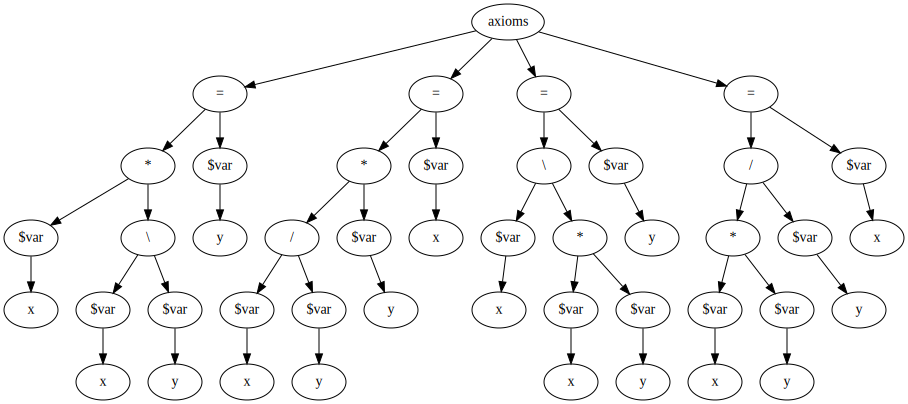

In [30]:
test_parse('Examples/quasigroups.eqn')

In [31]:
def parse_file(file_name):
    lexer.lineno = 1
    with open(file_name, 'r') as handle:
        program = handle.read() 
    AST = yacc.parse(program)
    if AST:
        _, *L = AST
        return L
    return None

In [32]:
parse_file('Examples/group-theory-1.eqn')

[('=', ('*', ('1',), ('$var', 'x')), ('$var', 'x')),
 ('=', ('*', ('i', ('$var', 'x')), ('$var', 'x')), ('1',)),
 ('=',
  ('*', ('*', ('$var', 'x'), ('$var', 'y')), ('$var', 'z')),
  ('*', ('$var', 'x'), ('*', ('$var', 'y'), ('$var', 'z'))))]

In [33]:
def parse_equation(s):
    lexer.lineno = 1
    AST = yacc.parse(s + ';')
    if AST:
        _, *L = AST
        return L[0]
    return None

In [34]:
parse_equation('i(x) * x = 1')

('=', ('*', ('i', ('$var', 'x')), ('$var', 'x')), ('1',))

In [35]:
def parse_term(s):
    lexer.lineno = 1
    AST = yacc.parse(s + '= 1;')
    if AST:
        _, *L = AST
        return L[0][1]
    return None

In [36]:
parse_term('i(x) * x')

('*', ('i', ('$var', 'x')), ('$var', 'x'))

In [37]:
def to_str(t):
    if isinstance(t, set):
        return '{' + ', '.join({ f'{to_str(eq)}' for eq in t }) + '}'
    if isinstance(t, list):
        return '[' + ', '.join([ f'{to_str(eq)}' for eq in t ]) + ']'
    if isinstance(t, dict):
        return '{' + ', '.join({ f'{k}: {to_str(v)}' for k, v in t.items() }) + '}'
    if isinstance(t, str):
        return t
    if t[0] == '$var':
        return t[1]
    if len(t) == 3 and t[0] in ['=']:
        _, lhs, rhs = t
        return f'{to_str(lhs)} = {to_str(rhs)}'
    if t[0] == '\\':
        op, lhs, rhs = t
        return to_str_paren(lhs) + ' \\ ' + to_str_paren(rhs)
    if len(t) == 3 and t[0] in ['+', '-', '*', '/', '%', '^']:
        op, lhs, rhs = t
        return f'{to_str_paren(lhs)} {op} {to_str_paren(rhs)}'
    f, *Args = t
    if Args == []:
        return f
    return f'{f}({to_str_list(Args)})'

In [38]:
def to_str_paren(t):
    if isinstance(t, str):
        return t
    if t[0] == '$var':
        return t[1]
    if len(t) == 3:
        op, lhs, rhs = t
        return f'({to_str_paren(lhs)} {op} {to_str_paren(rhs)})'
    f, *Args = t
    if Args == []:
        return f
    return f'{f}({to_str_list(Args)})'

In [39]:
def to_str_list(TL):
    if TL == []:
        return ''
    t, *Ts = TL
    if Ts == []:
        return f'{to_str(t)}'
    return f'{to_str(t)}, {to_str_list(Ts)}'